In [ ]:
!pip install -U xgboost scikit-learn scipy albumentations git+git://github.com/slundberg/shap@v0.40.0

     |████████████████████████████████| 102 kB 5.7 MB/s 
     |████████████████████████████████| 47.6 MB 178 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import numpy as np
import pickle
import os

import scipy.sparse as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, 
    hamming_loss, 
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, average_precision_score,
    label_ranking_loss, label_ranking_average_precision_score, coverage_error,
    log_loss, roc_auc_score, brier_score_loss,
    confusion_matrix, multilabel_confusion_matrix, 
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, auc,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer

import xgboost as xgb

import sys
sys.path.append('./drive/MyDrive/spotify/notebooks/')
from utils import *

from shap.plots._labels import labels as shap_labels
shap_labels['FEATURE_VALUE_HIGH'] = 'Alto'
shap_labels['FEATURE_VALUE_LOW'] = 'Bajo'
shap_labels['FEATURE_VALUE'] = 'Valor de característica'
import shap
shap.plots._waterfall.plt = plt

ROOT_PATH = "./drive/MyDrive/spotify/training/loud/10000/7/"
RESULTS_PATH = "./drive/MyDrive/spotify/results/"
SONGS_PATH = "./drive/MyDrive/spotify/raw/songs_merged.csv"
FIG_PATH = "./drive/MyDrive/spotify/fig/"
TABLE_PATH = "./drive/MyDrive/spotify/tables/"

CLUSTER_NAMES = ['Electrónica', 'Instrumental', 'Rock', 'Rap', 'Indie', 'Pop', 'Latina']
FEATURE_NAMES = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key', 'mode', 'time_signature', 'explicit', 'duration_ms']

In [ ]:
def get_threshold(ytrue, yprobs):
    unique_probs = set(yprobs[yprobs <= 0.5])
    best_score, best_thresh = 0, None
    for i, prob in enumerate(unique_probs):
        score = f1_score(ytrue, yprobs > prob)
        if score > best_score:
            best_score = score
            best_thresh = prob
    return best_thresh, best_score

In [ ]:
feature_cols =  ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
param_cols = ['colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'min_child_weight', 'subsample']

In [ ]:
df_songs = pd.read_csv(SONGS_PATH, usecols=['id', 'name'])
df_songs = df_songs.set_index('id')

In [ ]:
top_genres = [
    ['electro house', 'edm', 'progressive house', 'house', 'electronica'],
    ['lo-fi beats', 'soundtrack', 'neo-classical', 'compositional ambient', 'ambient'],
    ['metalcore', 'melodic metalcore', 'melodic hardcore', 'metal', 'post-screamo'],
    ['rap', 'hip hop', 'german hip hop', 'french hip hop', 'underground hip hop'],
    ['indie folk', 'folk', 'stomp and holler', 'c-pop', 'new americana'],
    ['pop', 'dance pop', 'electropop', 'post-teen pop', 'country pop'],
    ['corrido', 'tropical', 'regional mexican', 'nuevo regional mexicano', 'latin']
]
top_genres = [sorted(x) for x in top_genres]
top_genres_flat = [x for subl in top_genres for x in subl]
topk = set([x for subl in top_genres for x in subl])

In [ ]:
df_comb = pd.DataFrame()
encoders = [None] * 7
for k in range(7):
    df_temp = pd.read_csv(os.path.join(ROOT_PATH, f"genres/examples{k}.csv"))
    df_temp['cluster'] = k
    df_temp = df_temp[df_temp['genre'].isin(topk)]

    df_comb = pd.concat([df_comb, df_temp])

In [ ]:
df_labels = df_comb[['cluster', 'genre']].drop_duplicates()
df_labels = df_labels.sort_values(['cluster', 'genre'])
class_order = list(df_labels['genre'])
df_labels['cluster_idx'] = [i for _ in range(7) for i in range(5)]
df_labels = df_labels.sort_values('genre')
df_labels['genre_idx'] = range(35)

In [ ]:
clasif = [[None for _ in range(5)] for _ in range(7)]
clasif_bad = [[None for _ in range(5)] for _ in range(7)]

for _, row in df_labels.iterrows():
    i, j, k = row['genre_idx'], row['cluster'], row['cluster_idx']
    
    bst = xgb.Booster()
    bst.load_model(os.path.join(RESULTS_PATH, f"genres/models/model_{j}_{k}.json"))
    clasif[j][k] = bst

    bst_bad = xgb.Booster()
    bst_bad.load_model(os.path.join(RESULTS_PATH, f"genres_bad/models/model_{i}.json"))
    clasif_bad[j][k] = bst_bad

In [ ]:
super_clasif = [None] * 7
for i in range(7):
    bst = xgb.Booster()
    bst.load_model(os.path.join(RESULTS_PATH, f"supergenres/models/model_{i}.json"))
    super_clasif[i] = bst

In [ ]:
with open(os.path.join(ROOT_PATH, 'genres/X_test_all.pkl'), 'rb') as f:
    X_test = pickle.load(f)

with open(os.path.join(ROOT_PATH, 'genres/y_test_all.pkl'), 'rb') as f:
    y_test_u = pickle.load(f)

y_test = np.empty(y_test_u.shape)
for i, j in enumerate(np.argsort(class_order)):
    y_test[:, j] = y_test_u[:, i]

dtest = xgb.DMatrix(data=X_test)

In [ ]:
class DummyClassifier:
    def __init__(self, prob=0.5):
        self.prob = prob

    def predict(self, dmat):
        return np.ones(dmat.num_row()) * self.prob

class HierarchicalClassifier:
    def __init__(self, super_clfs, clfs):
        assert len(super_clfs) == len(clfs), "Parent and children classifiers must be the same size."
        self.super_clfs = super_clfs
        self.clfs = clfs


    @property
    def n_superclasses(self):
        return len(self.super_clfs)


    @property
    def n_classes(self):
        out = [None] * self.n_superclasses
        for i in range(self.n_superclasses):
            out[i] = len(self.clfs[i])
        return out


    @property
    def n_classes_flat(self):
        return sum(self.n_classes)


    @property
    def dense(self):
        out = True
        for clf in self.clfs:
            if len(clf) != len(self.clfs[0]):
                out = False
                break
        return out


    def predict_top(self, dmat):
        out = np.empty([dmat.num_row(), len(self.super_clfs)])
        for i, clf in enumerate(self.super_clfs):
            out[:, i] = clf.predict(dmat)
        return out


    def predict_bot_stage(self, dmat, i):
        out = np.empty([dmat.num_row(), len(self.clfs[i])])
        for i, clf in enumerate(self.clfs[i]):
            out[:, i] = clf.predict(dmat)
        return out


    def predict_bot(self, dmat):
        if self.dense:
            out = np.empty([dmat.num_row(), self.n_superclasses, self.n_classes[0]])
        else:
            raise NotImplementedError

        for i in range(len(self.super_clfs)):
            out[:, i, :] = self.predict_bot_stage(dmat, i)
        return out


    def predict_proba(self, X, hint_top=None, hint_bot=None):
        dmat = xgb.DMatrix(data=X)

        if hint_top is None:
            pred_top = self.predict_top(dmat)
        else:
            pred_top = hint

        if hint_bot is None:
            pred_bot = self.predict_bot(dmat)
        else:
            pred_bot = hint_bot
            
        pred_scaled = pred_top[:, :, np.newaxis] * pred_bot
        return pred_scaled.reshape(X.shape[0], self.n_classes)

    def _path_proba(self, X, prob_bot=None, prob_top=None):
        dmat = xgb.DMatrix(X)

        if prob_bot is None:
            prob_bot = self.predict_bot(dmat)
        
        if prob_top is None:
            prob_top = self.predict_top(dmat)

        return prob_bot, prob_top

    
    def _path_dispatcher(self, prob_bot, prob_top, t=0.5, w=None):
        pred_bot_wrong = prob_bot > t

        layers = np.where(pred_bot_wrong, prob_bot, 0)
        sum_p = layers.sum(axis=2)
        phi_size = np.count_nonzero(layers, axis=2)
        if w is None:
            prob_top_adj = (prob_top + sum_p) / (1 + phi_size)
        else:
            num = (1 - w) * sum_p
            den = phi_size
            out = (1 - w) * prob_top
            s = np.divide(num, den, out=out, where=den!=0)
            prob_top_adj = w * prob_top + s

        pred_top = (prob_top_adj > t).astype(int)

        pred_bot = np.where(pred_top[:, :, np.newaxis], pred_bot_wrong, 0)

        return pred_top, pred_bot


    def predict_path(self, X, prob_bot=None, prob_top=None, t=0.5, w=None):
        prob_bot, prob_top = self._path_proba(X, hint_bot, hint_top)        
        return self._path_dispatcher(prob_bot, prob_top, t=t, w=w)
        
        
    def predict_fast(self, X, thresh_1=0.5, thresh_2=0.5, hint=None):
        out = np.zeros((X.shape[0], self.n_classes_flat))
        dmat = xgb.DMatrix(data=X)

        if hint is None:
            pred_top = self.predict_top(dmat) > thresh_1
            clf_series, point_series = pred_top.T.nonzero()
        else:
            raise NotImplementedError

        clf_list = [clf_series[0]]
        chunk_idx = []
        last_idx = None
        for i, num in enumerate(clf_series):
            if num != clf_list[-1]:
                clf_list.append(num)
                chunk_idx.append(point_series[last_idx:i])
                last_idx = i
        chunk_idx.append(point_series[last_idx:])

        strides = [sum(lens[:i]) for i in range(self.n_superclasses)]
        strides.append(None)
        for clf_idx, point_idx in zip(clf_list, chunk_idx):
            dtemp = xgb.DMatrix(data=X[point_idx])
            out[point_idx, strides[clf_idx]:strides[clf_idx+1]] = self.predict_bot_stage(dtemp, clf_idx)

        return out > thresh_2

In [ ]:
super_clasif_bad = [DummyClassifier(prob=1) for _ in range(7)]

handler = HierarchicalClassifier(super_clasif, clasif)
handler_bad = HierarchicalClassifier(super_clasif_bad, clasif_bad)

In [ ]:
hint_top = np.empty([y_test.shape[0], 7])
for k in range(7):
    t = y_test[:, k*5:(k+1)*5] == 1
    hint_top[:, k] = t.any(axis=1)

hint_bot = y_test.reshape((X_test.shape[0], 7, 5))

In [ ]:
prob_bot, prob_top = handler._path_proba(X_test)

In [ ]:
num_t = 100
num_w = 10
n_classes = 35
n_points = X_test.shape[0]

precisions = np.empty((num_t, num_w, n_classes))
recalls = np.empty((num_t, num_w, n_classes))
f1_scores = np.empty((num_t, num_w, n_classes))

for i, t in enumerate(np.linspace(0, 1, num_t)):
    for j, w in enumerate(np.linspace(0, 1, num_w)):
        yhat = handler._path_dispatcher(prob_bot, prob_top, t=t, w=w)
        yhat_flat = yhat[1].reshape((n_points, 35))
        
        for k in range(n_classes):
            precisions[i, j, k] = precision_score(y_test[:, k], yhat_flat[:, k], zero_division=0)
            recalls[i, j, k] = recall_score(y_test[:, k], yhat_flat[:, k])
            f1_scores[i, j, k] = f1_score(y_test[:, k], yhat_flat[:, k])
        print(i, j, end='\r')

In [ ]:
1

In [ ]:
average_precisions = [0] * n_classes

for k in range(n_classes):
    prec_inv = precisions[:, k][::-1]
    rec_inv = recalls[:, k][::-1]
    for i in range(1, n):    
        average_precisions[k] += (rec_inv[i] - rec_inv[i-1]) * prec_inv[i]

In [ ]:
average_precisions

[0.6180239649328424,
 0.6539646471615493,
 0.48062005954425757,
 0.6587344138350832,
 0.8469103060057611,
 0.4352406428474316,
 0.5483501689614112,
 0.6628735385597134,
 0.3568869585321265,
 0.7576494699791432,
 0.48761819799883294,
 0.4394934036389849,
 0.7407736647845162,
 0.46241227306189786,
 0.23740922984804785,
 0.3487796953339005,
 0.32861842469090924,
 0.5400476836452227,
 0.556803352757759,
 0.360146066499737,
 0.5193762872484865,
 0.5903414628678793,
 0.293101775983746,
 0.27158978926726723,
 0.288822184696884,
 0.3649416592122939,
 0.627922252554571,
 0.4815456278856613,
 0.5748363360299872,
 0.47966801631910955,
 0.8155743369059654,
 0.5153173319922684,
 0.5287072108921091,
 0.7513624978068011,
 0.7123772000116072]

0.6600338815696631


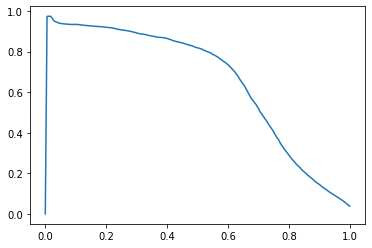

In [ ]:
i = 3
print(auc(recalls[:,i], precisions[:,i]))
plt.plot(recalls[:,i], precisions[:,i])

0.6006201964335199

In [ ]:
yhat = handler.predict_proba(X_test)
yhat_hint = handler.predict_proba(X_test, hint_top=hint_top)
yhat_bad = handler_bad.predict_proba(X_test)

In [ ]:
clf_names = ['Vanilla', 'Jerárquico', 'Jerárquico c/hint']

In [ ]:
prec_total = [
    average_precision_score(y_test, yhat_bad), 
    average_precision_score(y_test, yhat),
    average_precision_score(y_test, yhat_hint),
]

cov_total = [
    coverage_error(y_test, yhat_bad),
    coverage_error(y_test, yhat),
    coverage_error(y_test, yhat_hint),
]
perf_cov = coverage_error(y_test, y_test)

In [ ]:
df_results_all = pd.DataFrame(
    zip(clf_names, prec_total, cov_total), 
    columns=['Clasificador', 'Precisión', 'Cobertura']
)
df_results_all.to_csv(os.path.join(TABLE_PATH + 'results.csv'), index=False)

In [ ]:
sns.set(font_scale=2, style='ticks')

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(
    x = clf_names,
    y = prec_total,
    palette = 'mako',
    ax = ax,
)
ax.set_title("Precision")
fig.savefig(os.path.join(FIG_PATH, 'precision_all.png'), bbox_inches='tight', dpi=150)

In [ ]:
sns.set(font_scale=2, style='ticks')

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(
    x = clf_names,
    y = cov_total,
    palette = 'mako',
    ax = ax,
)
ax.axhline(perf_cov, 0, 1, c='k', ls='--')
ax.set_title("Coverage error")
fig.savefig(os.path.join(FIG_PATH, 'coverage_all.png'), bbox_inches='tight', dpi=150)

In [ ]:
prec = [None] * 35
prec_hint = [None] * 35
prec_bad = [None] * 35

brier = [None] * 35
brier_hint = [None] * 35
brier_bad = [None] * 35
for k in range(35):
    prec[k] = average_precision_score(y_test[:,k], yhat[:,k])
    prec_hint[k] = average_precision_score(y_test[:,k], yhat_hint[:,k])
    prec_bad[k] = average_precision_score(y_test[:,k], yhat_bad[:,k])

    brier[k] = brier_score_loss(y_test[:,k], yhat[:,k])
    brier_hint[k] = brier_score_loss(y_test[:,k], yhat_hint[:,k])
    brier_bad[k] = brier_score_loss(y_test[:,k], yhat_bad[:,k])

In [ ]:
df_prec = pd.DataFrame(zip(top_genres_flat, prec, prec_hint, prec_bad), columns=['genre'] + clf_names)
df_prec.to_csv(os.path.join(TABLE_PATH, 'precision_by_genre.csv'), index=False)

In [ ]:
df_brier = pd.DataFrame(zip(top_genres_flat, brier, brier_hint, brier_bad), columns=['genre'] + clf_names)
df_brier.to_csv(os.path.join(TABLE_PATH, 'brier_loss_by_genre.csv'), index=False)

In [ ]:
sns.set(font_scale=1.5, style='ticks')

label_bar = [clf_names[i] for i in range(3) for _ in range(5)]

for n in range(7):
    i, j = 5*n, 5*(n+1)
    x_bar = [top_genres[n][k] for _ in range(3) for k in range(5)]
    y_bar = list(np.hstack([prec_bad[i:j], prec[i:j], prec_hint[i:j]]))
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(
        x = x_bar,
        y = y_bar,
        hue = label_bar,
        palette = 'mako'
    )
    ax.set_title(f"Cluster {n} precisión promedio")
    plt.legend(bbox_to_anchor=(0, 1.05), loc="lower left", ncol=3)
    ax.set_xticklabels(x_bar, rotation=20, ha='right')
    fig.savefig(os.path.join(FIG_PATH, f'precision_{n}.png'), bbox_inches='tight', dpi=150)
    # plt.close()

In [ ]:
sns.set(font_scale=1.5, style='ticks')

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(7):
    precision, recall, _ = precision_recall_curve(hint_top[:,i], top_yhat[:,i])
    sns.lineplot(
        x = recall,
        y = precision,
        ci = None,
        label = CLUSTER_NAMES[i],
        linewidth = 3,
        ax = ax,
    )
ax.set_xlabel('Sensibilidad')
ax.set_ylabel('Precisión')
fig.savefig(os.path.join(FIG_PATH, 'prc.png'), bbox_inches='tight', dpi=150)

# Explain

In [ ]:
df_test = pd.DataFrame(X_test, columns=FEATURE_NAMES)

In [ ]:
explainer = shap.explainers.GPUTree(
    handler.super_clfs[0], 
    df_test,
)
shap_values = explainer(df_test)
shap_values_mat = explainer.shap_values(df_test)

In [ ]:
1

1

In [ ]:
for i in range(0, 7):
    explainer = shap.explainers.GPUTree(
        handler.super_clfs[i], 
        df_test,
    )
    shap_values = explainer(df_test)

    with open(f"./drive/MyDrive/spotify/pickles/explainer_{i}.pkl", 'wb') as f:
        pickle.dump(explainer, f)

    with open(f"./drive/MyDrive/spotify/pickles/shap_values_{i}.pkl", 'wb') as f:
        pickle.dump(shap_values, f)

In [ ]:
explainers = [None] * 7
shap_values = [None] * 7
for i in range(7):
    with open(f"./drive/MyDrive/spotify/pickles/explainer_{i}.pkl", 'rb') as f:
        explainers[i] = pickle.load(f)

    with open(f"./drive/MyDrive/spotify/pickles/shap_values_{i}.pkl", 'rb') as f:
        shap_values[i] = pickle.load(f)

In [ ]:
CLUSTER_NAMES

['Electrónica', 'Instrumental', 'Rock', 'Rap', 'Indie', 'Pop', 'Latina']

In [ ]:
1

1

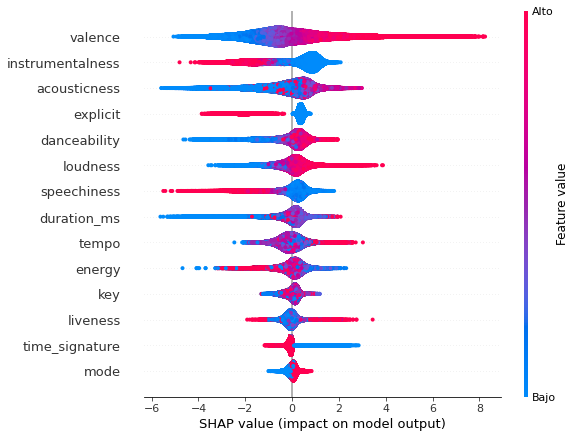

In [ ]:
shap.plots.beeswarm(shap_values[6], max_display=15)

In [ ]:
shap.plots.decision(explainer.expected_value, shap_values[:1000], X_test[:1000])

TypeError: ignored